# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

## Reading the data from SQLITE
1. We are going to classify our data using the attribute "SCORE" from our dataframe
2. SCORE > 3 is classified as Positive review, SCORE < 3 is classified as Negative review
3. Since SCORE = 3 is Neutral, we will not consider those reviews in our classiication

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 


filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

### Data Cleaning: Removing miscategorized data points

1. The products "B00004CI84" and "B00004CXX9" belong to movie category. Since the product name contains the word "Juice", it has been miscategorized under food.

2. "B0002YW26E" is a Pest control product. Miscategorized as food.

3. The products "6641040" and "2841233731" are CookBooks.

In [14]:
# Removing the miscategorized products from the data

final_data=final[~final.ProductId.isin (['B0002YW26E','B00004CI84','B00004CXX9','6641040','2841233731'])]
print("Number of final points in our data",final_data.shape)

Number of final points in our data (363896, 10)


In [15]:
#How many positive and negative reviews are present in our dataset?
print(final_data['Score'].value_counts())

1    306829
0     57067
Name: Score, dtype: int64


#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [16]:
# printing some random reviews
sent_238 = final_data['Text'].values[238]
print(sent_238)
print("*"*100)

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_238 = re.sub(r"http\S+", "", sent_238)
print(sent_238)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
import lxml
from bs4 import BeautifulSoup

print(sent_238)
print("*"*100)
soup = BeautifulSoup(sent_238, 'html.parser')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

sent_79290 = final_data['Text'].values[79290]
print(sent_79290)
print("*"*100)
sent_79290 = decontracted(sent_79290)
print(sent_79290)

I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can't find them.
****************************************************************************************************
I buy these at Christmas time to stuff for parties.  They are a hit and getting hard to find.  :) Some wait for my tray of stuffed peppers with anticipation, and will be disappointed this year if I can not find them.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
print(text)
print("*"*100)
text = re.sub("\S*\d\S*", "", text).strip()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************
Why is this $[...] when the same product is available for $[...] here? />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
text = re.sub('[^A-Za-z0-9]+', ' ', text)
print(text)

Why is this when the same product is available for here The Victor and traps are unreal of course total fly genocide Pretty stinky but only right nearby 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final_data['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'html.parser').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|██████████| 363896/363896 [01:26<00:00, 4199.03it/s]


In [23]:
preprocessed_reviews[1600]

'cats love product not worry clay getting digested cats family matter one cats getting sick clay tried since natural voila healthy kitties sure may not work new fangled litter boxes not think made scoop litter must sit probably min stay ball love counts plus price awesome usually travel half hours get shipping worth gas travel time thank'

In [24]:
final_data['CleanedText']=preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of review
print(final_data['CleanedText'].values[100])

purchased several different brands liver treats best terms good size pieces small bits little powder


# [4] Featurization

In [92]:
# Taking 50k points from our dataset

final_sample = final_data.sample(n=50000)
print(final_sample.shape)
print(final_sample["Score"].shape)

(50000, 11)
(50000,)


In [93]:
# Sorting the data based on time

final_sample.sort_values(by='Time', ascending=True, inplace=True)
print(final_sample['Time'].head(1))
print(final_sample['Time'].tail(1))

333922    1023321600
Name: Time, dtype: int64
135216    1351209600
Name: Time, dtype: int64


In [94]:
import sklearn.model_selection as model_selection
from sklearn.neighbors import KNeighborsClassifier

# split the data set into train and test
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(final_sample, final_sample["Score"], shuffle=False,test_size=0.2)

print("No of data points in training dataset", X_tr.shape)
print("No of data points in test dataset", X_test.shape)
print(y_tr.value_counts())

No of data points in training dataset (40000, 11)
No of data points in test dataset (10000, 11)
1    33877
0     6123
Name: Score, dtype: int64


In [95]:
print(X_tr['Time'].head(1))
print(X_tr['Time'].tail(1))

print('********************************')

print(X_test['Time'].head(1))
print(X_test['Time'].tail(1))

333922    1023321600
Name: Time, dtype: int64
242877    1337126400
Name: Time, dtype: int64
********************************
215510    1337126400
Name: Time, dtype: int64
135216    1351209600
Name: Time, dtype: int64


## [4.1] Applying KNN brute force

## [4.1.1] Applying KNN brute force on BOW

In [29]:
#BoW: 
count_vect = CountVectorizer() 
final_counts_train = count_vect.fit_transform(X_tr['CleanedText'].values)
print("The shape of train text BOW vectorizer ",final_counts_train.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler(with_mean=False).fit_transform(final_counts_train)

The shape of train text BOW vectorizer  (40000, 38794)


In [33]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_bow, y_train_bow = sm.fit_resample(standardized_data_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_bow))

Resampled dataset shape Counter({0: 33875, 1: 33875})


In [34]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_bow).items()))

Train data before upsampling:  [(0, 6125), (1, 33875)]
Train data after upsampling :  [(0, 33875), (1, 33875)]


In [35]:
#BoW: 
final_counts_test = count_vect.transform(X_test['CleanedText'].values)
print("The shape of test text BOW vectorizer ",final_counts_test.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
X_test_bow = StandardScaler(with_mean=False).fit_transform(final_counts_test)

The shape of test text BOW vectorizer  (10000, 38794)


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')
Training Accuracy: 0.9647863326479759
Test Accuracy: 0.7031443513029801


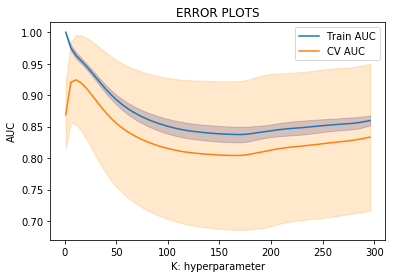

In [36]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,300,5))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='brute',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_bow, y_train_bow)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_bow,y_train_bow))
print("Test Accuracy:",clf.score(X_test_bow,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 11}
AUC score on train data:  0.9647863326479759
AUC score on test data:  0.7031443513029801


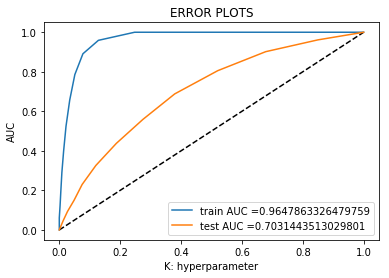

Train confusion matrix
[[33128   747]
 [16115 17760]]
Test confusion matrix
[[1386  320]
 [4661 3633]]


In [37]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='brute',n_jobs= -1)
neigh.fit(X_train_bow, y_train_bow)

y_pred_proba_train = neigh.predict_proba(X_train_bow)[:,1]
y_pred_proba_test = neigh.predict_proba(X_test_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_bow, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

## [4.1.2] Applying KNN brute force on TFIDF

In [160]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tf_idf_tr = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)
print("The shape of train TFIDF vectorizer ",tf_idf_tr.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
x_scaled_tr = StandardScaler(with_mean=False).fit_transform(tf_idf_tr)

The shape of train TFIDF vectorizer  (40000, 803163)


In [161]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf, y_train_tfidf = sm.fit_resample(x_scaled_tr, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf))

Resampled dataset shape Counter({0: 33860, 1: 33860})


In [162]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf).items()))

Train data before upsampling:  [(0, 6140), (1, 33860)]
Train data after upsampling :  [(0, 33860), (1, 33860)]


In [163]:
tf_idf_test = tf_idf_vect.transform(X_test['CleanedText'].values)
print("The shape of test TFIDF vectorizer ",tf_idf_test.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
X_test_tfidf = StandardScaler(with_mean=False).fit_transform(tf_idf_test)

The shape of test TFIDF vectorizer  (10000, 803163)


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')
Training Accuracy: 0.9961646981821886
Test Accuracy: 0.6083160570093552


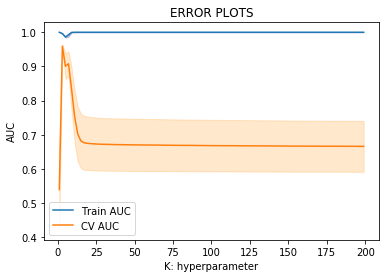

In [164]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,200,2))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='brute',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_tfidf, y_train_tfidf)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_tfidf,y_train_tfidf))
print("Test Accuracy:",clf.score(X_test_tfidf,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 3}
AUC score on train data:  0.9961646981821886
AUC score on test data:  0.6083160570093552


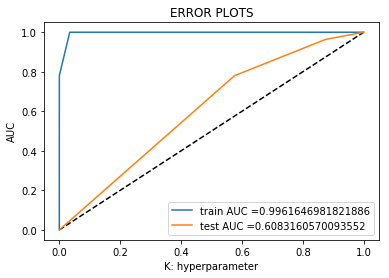

Train confusion matrix
[[33855     5]
 [ 7429 26431]]
Test confusion matrix
[[ 735  997]
 [1818 6450]]


In [165]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='brute',n_jobs= -1)
neigh.fit(X_train_tfidf, y_train_tfidf)

y_pred_proba_train = neigh.predict_proba(X_train_tfidf)[:,1]
y_pred_proba_test = neigh.predict_proba(X_test_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))

## Word2Vec

In [96]:
# Train the Word2Vec model using text corpus
i=0
list_of_sent_train=[]
list_of_sent_test=[]
for sent in X_tr['CleanedText'].values:
    list_of_sent_train.append(sent.split())
    
for sent in X_test['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [97]:
# Train data
print(X_tr['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_train[0])
print("*****************************************************************")

# Test data
print(X_test['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent_test[0])

using briel chamonix machine purchased amazon produced delicious lattes using pods smell espressione pods regular decaf opened incredible dark rich roasts fyi pods produced italy good sign also pod handy paper tab remove machine without burning fingers compared pods starbucks espresso pods regular decaf espressione favorite one warning pods individually wrapped take lot space sure know going store good news box stamped best used date case months date purchase
*****************************************************************
['using', 'briel', 'chamonix', 'machine', 'purchased', 'amazon', 'produced', 'delicious', 'lattes', 'using', 'pods', 'smell', 'espressione', 'pods', 'regular', 'decaf', 'opened', 'incredible', 'dark', 'rich', 'roasts', 'fyi', 'pods', 'produced', 'italy', 'good', 'sign', 'also', 'pod', 'handy', 'paper', 'tab', 'remove', 'machine', 'without', 'burning', 'fingers', 'compared', 'pods', 'starbucks', 'espresso', 'pods', 'regular', 'decaf', 'espressione', 'favorite', 'one'

In [98]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)

In [99]:
w2v_words_train = list(w2v_model_train.wv.vocab)
w2v_words_test = list(w2v_model_test.wv.vocab)
print("Number of words that occured minimum 5 times in the train data: ",len(w2v_words_train))
print("Number of words that occured minimum 5 times in the test data: ",len(w2v_words_test))
print("Sample words in train data: ", w2v_words_train[0:50])

Number of words that occured minimum 5 times in the train data:  12322
Number of words that occured minimum 5 times in the test data:  6180
Sample words in train data:  ['sensory', 'veterinary', 'kimchi', 'fusions', 'promising', 'nugget', 'attacked', 'kipper', 'cooked', 'beat', 'stains', 'bummed', 'incidentally', 'becomes', 'keys', 'marvellous', 'torani', 'concept', 'resembled', 'phenomenal', 'farmed', 'sorts', 'stinky', 'choosing', 'wave', 'goals', 'vodka', 'kitchens', 'commonly', 'fiber', 'however', 'nb', 'classmates', 'ex', 'held', 'whichever', 'contacted', 'enriched', 'sludge', 'purina', 'sale', 'reveals', 'terry', 'translate', 'solids', 'scares', 'bursting', 'crank', 'vines', 'stupid']


In [100]:
w2v_model_train.wv.most_similar('taste')

[('flavor', 0.8475456833839417),
 ('tastes', 0.7809020280838013),
 ('aftertaste', 0.7644829750061035),
 ('tasting', 0.746143639087677),
 ('sounds', 0.7199762463569641),
 ('flavour', 0.7035329341888428),
 ('gritty', 0.6794748306274414),
 ('expecting', 0.6694208383560181),
 ('smells', 0.6629433035850525),
 ('palate', 0.6610968708992004)]

## [4.1.3] Applying KNN brute force on AVG W2V

In [65]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 40000/40000 [05:50<00:00, 114.03it/s]

40000
50


In [66]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_w2v, y_train_w2v = sm.fit_resample(sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_w2v))

Resampled dataset shape Counter({0: 33868, 1: 33868})


In [67]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_w2v).items()))

Train data before upsampling:  [(0, 6132), (1, 33868)]
Train data after upsampling :  [(0, 33868), (1, 33868)]


In [68]:
# average Word2Vec for test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 10000/10000 [00:29<00:00, 344.53it/s]

10000
50


In [69]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(X_train_w2v)
standardized_data_test = StandardScaler().fit_transform(sent_vectors_test)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=13, p=2,
           weights='uniform')
Training Accuracy: 0.9809911041190087
Test Accuracy: 0.6556217732669263


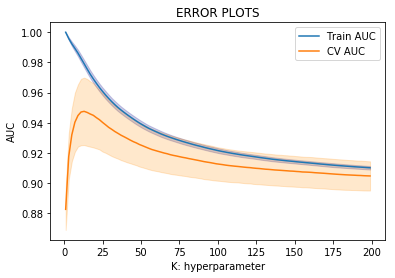

In [70]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,200,2))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='brute',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 13}
AUC score on train data:  0.9809911041190087
AUC score on test data:  0.6556217732669263


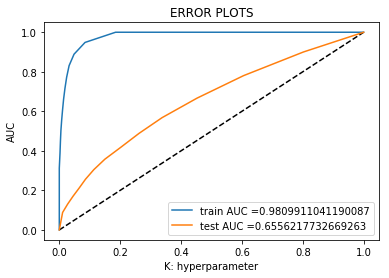

Train confusion matrix
[[33388   480]
 [11450 22418]]
Test confusion matrix
[[1483  261]
 [5303 2953]]


In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='brute',n_jobs= -1)
neigh.fit(standardized_data_train, y_train_w2v)

y_pred_proba_train = neigh.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = neigh.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_w2v, neigh.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(standardized_data_test)))

## [4.1.4] Applying KNN brute force on TFIDF W2V

In [101]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_tr['CleanedText'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [102]:
tf_idf_matrix_test = model.transform(X_test['CleanedText'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [103]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_train)
            weight_sum += tf_idf_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 40000/40000 [24:09<00:00, 27.60it/s]


In [104]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf_w2v, y_train_tfidf_w2v = sm.fit_resample(tfidf_sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf_w2v))

Resampled dataset shape Counter({0: 33877, 1: 33877})


In [109]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf_w2v).items()))

Train data before upsampling:  [(0, 6123), (1, 33877)]
Train data after upsampling :  [(0, 33877), (1, 33877)]


In [110]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_test)
            weight_sum += tf_idf_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [04:35<00:00, 48.03it/s]


In [111]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(X_train_tfidf_w2v)
standardized_data_test = StandardScaler().fit_transform(tfidf_sent_vectors_test)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')
Training Accuracy: 0.9791721984181484
Test Accuracy: 0.6086335203588434


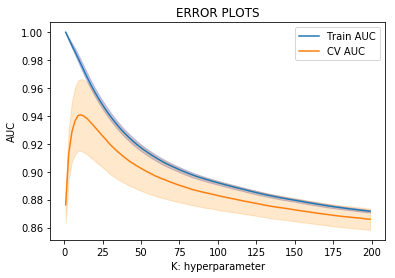

In [112]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,200,2))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='brute',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_tfidf_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_tfidf_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 11}
AUC score on train data:  0.9791721984181484
AUC score on test data:  0.6086335203588434


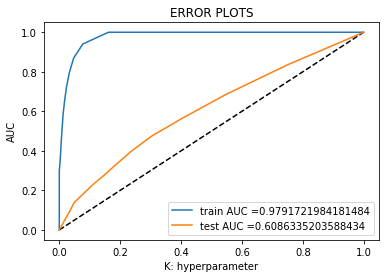

Train confusion matrix
[[33275   602]
 [11606 22271]]
Test confusion matrix
[[1449  336]
 [5477 2738]]


In [115]:
# from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='brute',n_jobs= -1)
neigh.fit(standardized_data_train, y_train_tfidf_w2v)

y_pred_proba_train = neigh.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = neigh.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf_w2v, neigh.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(standardized_data_test)))

## [5.1] Applying KNN kd-tree 

In [25]:
# Taking 20k points from our dataset

final_sample = final_data.sample(n=20000)
print(final_sample.shape)
print(final_sample["Score"].shape)

(20000, 11)
(20000,)


In [26]:
# Sorting the data based on time

final_sample.sort_values(by='Time', ascending=True, inplace=True)
print(final_sample['Time'].head(1))
print(final_sample['Time'].tail(1))

1145    962236800
Name: Time, dtype: int64
516763    1351209600
Name: Time, dtype: int64


In [27]:
import sklearn.model_selection as model_selection
from sklearn.neighbors import KNeighborsClassifier

# split the data set into train and test
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(final_sample, final_sample["Score"], shuffle=False,test_size=0.2)

print("No of data points in training dataset", X_tr.shape)
print("No of data points in test dataset", X_test.shape)
print(y_tr.value_counts())

No of data points in training dataset (16000, 11)
No of data points in test dataset (4000, 11)
1    13547
0     2453
Name: Score, dtype: int64


In [28]:
print(X_tr['Time'].head(1))
print(X_tr['Time'].tail(1))

print('********************************')

print(X_test['Time'].head(1))
print(X_test['Time'].tail(1))

1145    962236800
Name: Time, dtype: int64
148046    1337040000
Name: Time, dtype: int64
********************************
474481    1337040000
Name: Time, dtype: int64
516763    1351209600
Name: Time, dtype: int64


## [5.1.1] Applying KNN kd-tree on BOW

In [197]:
#BoW: 
count_vect = CountVectorizer(min_df=10, max_features=500) 
final_counts_train = count_vect.fit_transform(X_tr['CleanedText'].values)
print("The shape of train text BOW vectorizer ",final_counts_train.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler(with_mean=False).fit_transform(final_counts_train)

# Converting sparse matrices to dense
standardized_data_train_dense =standardized_data_train.toarray()

The shape of train text BOW vectorizer  (16000, 500)


In [141]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_bow, y_train_bow = sm.fit_resample(standardized_data_train_dense, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_bow))

Resampled dataset shape Counter({0: 13508, 1: 13508})


In [142]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_bow).items()))

Train data before upsampling:  [(0, 2492), (1, 13508)]
Train data after upsampling :  [(0, 13508), (1, 13508)]


In [143]:
#BoW: 
final_counts_test = count_vect.transform(X_test['CleanedText'].values)
print("The shape of test text BOW vectorizer ",final_counts_test.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_test = StandardScaler(with_mean=False).fit_transform(final_counts_test)

# Converting sparse matrices to dense
X_test_bow =standardized_data_test.toarray()

The shape of test text BOW vectorizer  (4000, 500)


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')
Training Accuracy: 0.9703878333233515
Test Accuracy: 0.6993298536700134


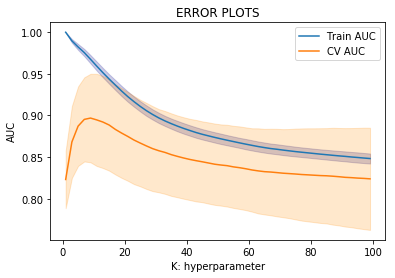

In [144]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,100,2))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='kd_tree',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_bow, y_train_bow)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_bow,y_train_bow))
print("Test Accuracy:",clf.score(X_test_bow,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 9}
AUC score on train data:  0.9703878333233515
AUC score on test data:  0.6993298536700134


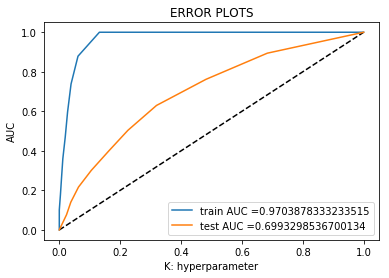

Train confusion matrix
[[13245   263]
 [ 7174  6334]]
Test confusion matrix
[[ 598  116]
 [1974 1312]]


In [145]:
# from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='kd_tree',n_jobs= -1)
neigh.fit(X_train_bow, y_train_bow)

y_pred_proba_train = neigh.predict_proba(X_train_bow)[:,1]
y_pred_proba_test = neigh.predict_proba(X_test_bow)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_bow, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_bow, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_bow, neigh.predict(X_train_bow)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_bow)))

## [5.1.2] Applying KNN kd-tree on TFIDF

In [202]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)
tf_idf_tr = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)
print("The shape of train TFIDF vectorizer ",tf_idf_tr.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler(with_mean=False).fit_transform(tf_idf_tr)

# Converting sparse matrices to dense
standardized_data_train_dense =standardized_data_train.toarray()

The shape of train TFIDF vectorizer  (16000, 500)


In [203]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf, y_train_tfidf = sm.fit_resample(standardized_data_train_dense, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf))

Resampled dataset shape Counter({0: 13534, 1: 13534})


In [204]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf).items()))

Train data before upsampling:  [(0, 2466), (1, 13534)]
Train data after upsampling :  [(0, 13534), (1, 13534)]


In [205]:
tf_idf_test = tf_idf_vect.transform(X_test['CleanedText'].values)
print("The shape of test TFIDF vectorizer ",tf_idf_test.get_shape())

# Data-preprocessing: Standardizing the data

from sklearn.preprocessing import StandardScaler
standardized_data_test = StandardScaler(with_mean=False).fit_transform(tf_idf_test)

# Converting sparse matrices to dense
X_test_tfidf =standardized_data_test.toarray()

The shape of test TFIDF vectorizer  (4000, 500)


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
           weights='uniform')
Training Accuracy: 0.9648270858440817
Test Accuracy: 0.5609751889070138


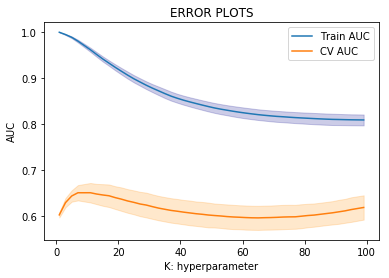

In [206]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,100,2))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='kd_tree',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(X_train_tfidf, y_train_tfidf)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(X_train_tfidf,y_train_tfidf))
print("Test Accuracy:",clf.score(X_test_tfidf,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 11}
AUC score on train data:  0.9648270858440817
AUC score on test data:  0.5609751889070138


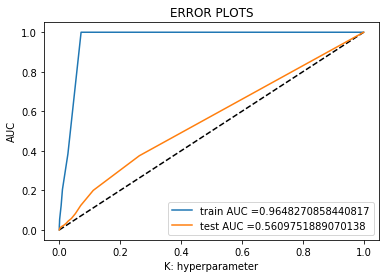

Train confusion matrix
[[13519    15]
 [12820   714]]
Test confusion matrix
[[ 661   20]
 [3170  149]]


In [209]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='kd_tree',n_jobs= -1)
neigh.fit(X_train_tfidf, y_train_tfidf)

y_pred_proba_train = neigh.predict_proba(X_train_tfidf)[:,1]
y_pred_proba_test = neigh.predict_proba(X_test_tfidf)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf, neigh.predict(X_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(X_test_tfidf)))

## Word2Vec

In [29]:
# Train the Word2Vec model using text corpus
i=0
list_of_sent_train=[]
list_of_sent_test=[]
for sent in X_tr['CleanedText'].values:
    list_of_sent_train.append(sent.split())
    
for sent in X_test['CleanedText'].values:
    list_of_sent_test.append(sent.split())

In [30]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model_train=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_model_test=Word2Vec(list_of_sent_test,min_count=5,size=50, workers=4)

In [31]:
w2v_words_train = list(w2v_model_train.wv.vocab)
w2v_words_test = list(w2v_model_test.wv.vocab)
print("Number of words that occured minimum 5 times in the train data: ",len(w2v_words_train))
print("Number of words that occured minimum 5 times in the test data: ",len(w2v_words_test))
print("Sample words in train data: ", w2v_words_train[0:50])

Number of words that occured minimum 5 times in the train data:  7937
Number of words that occured minimum 5 times in the test data:  3673
Sample words in train data:  ['richer', 'twinings', 'jarred', 'kansas', 'milder', 'slice', 'chewies', 'nutrient', 'needle', 'nibble', 'sniff', 'discounted', 'healthy', 'park', 'moral', 'dragging', 'commented', 'zojirushi', 'received', 'pound', 'hound', 'victoria', 'brick', 'peanut', 'bowels', 'guarantee', 'jet', 'gusto', 'spotted', 'whats', 'servings', 'hamburger', 'selling', 'complexity', 'lime', 'spice', 'subtle', 'sweet', 'translates', 'allergen', 'anti', 'guest', 'supplemented', 'float', 'extract', 'inedible', 'apricot', 'hopefully', 'season', 'breastfeeding']


## [5.1.3] Applying KNN kd-tree on AVG W2V

In [231]:
# average Word2Vec for train data
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 16000/16000 [01:33<00:00, 170.67it/s]

16000
50


In [232]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_w2v, y_train_w2v = sm.fit_resample(sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_w2v))

Resampled dataset shape Counter({0: 13608, 1: 13608})


In [233]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_w2v).items()))

Train data before upsampling:  [(0, 2392), (1, 13608)]
Train data after upsampling :  [(0, 13608), (1, 13608)]


In [234]:
# average Word2Vec for test data
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))


100%|██████████| 4000/4000 [00:06<00:00, 580.78it/s]

4000
50


In [235]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(X_train_w2v)
standardized_data_test = StandardScaler().fit_transform(sent_vectors_test)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')
Training Accuracy: 0.9827002893826331
Test Accuracy: 0.5579897551439761


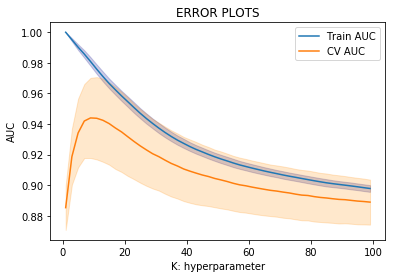

In [237]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,100,2))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='kd_tree',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 9}
AUC score on train data:  0.9827002893826331
AUC score on test data:  0.5579897551439761


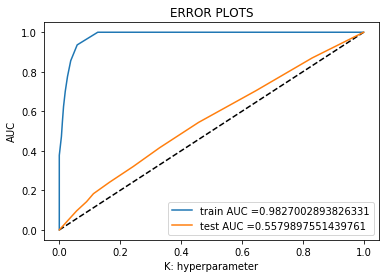

Train confusion matrix
[[13342   266]
 [ 4075  9533]]
Test confusion matrix
[[ 533  171]
 [2239 1057]]


In [238]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='kd_tree',n_jobs= -1)
neigh.fit(standardized_data_train, y_train_w2v)

y_pred_proba_train = neigh.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = neigh.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_w2v, neigh.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(standardized_data_test)))

## [5.1.4] Applying KNN kd-tree on TFIDF W2V

In [32]:
model = TfidfVectorizer()
tf_idf_matrix_train = model.fit_transform(X_tr['CleanedText'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_train = dict(zip(model.get_feature_names(), list(model.idf_)))

In [34]:
tf_idf_matrix_test = model.transform(X_test['CleanedText'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary_test = dict(zip(model.get_feature_names(), list(model.idf_)))

In [35]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train and word in tfidf_feat:
            vec = w2v_model_train.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_train = dictionary_train[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_train)
            weight_sum += tf_idf_train
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 16000/16000 [04:57<00:00, 53.77it/s]


In [36]:
# Balancing the train data
from imblearn.over_sampling import BorderlineSMOTE 
from collections import Counter

sm = BorderlineSMOTE(random_state=2)
X_train_tfidf_w2v, y_train_tfidf_w2v = sm.fit_resample(tfidf_sent_vectors_train, y_tr.ravel())
print('Resampled dataset shape %s' % Counter(y_train_tfidf_w2v))

Resampled dataset shape Counter({0: 13547, 1: 13547})


In [37]:
print("Train data before upsampling: ",sorted(Counter(y_tr).items()))
print("Train data after upsampling : ", sorted(Counter(y_train_tfidf_w2v).items()))

Train data before upsampling:  [(0, 2453), (1, 13547)]
Train data after upsampling :  [(0, 13547), (1, 13547)]


In [38]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_test and word in tfidf_feat:
            vec = w2v_model_test.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf_test = dictionary_test[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf_test)
            weight_sum += tf_idf_test
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1


100%|██████████| 4000/4000 [00:57<00:00, 69.60it/s]


In [39]:
# Data-preprocessing: Standardizing both train and test data

from sklearn.preprocessing import StandardScaler
standardized_data_train = StandardScaler().fit_transform(X_train_tfidf_w2v)
standardized_data_test = StandardScaler().fit_transform(tfidf_sent_vectors_test)

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
           weights='uniform')
Training Accuracy: 0.9783238513865719
Test Accuracy: 0.5384579718978221


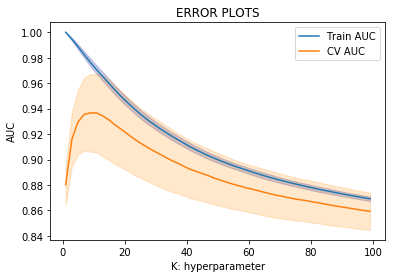

In [40]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

# define the parameter values that should be searched
k_range = list(range(1,100,2))

param_grid = dict(n_neighbors=k_range)

# instantiate the grid
neigh = KNeighborsClassifier(algorithm='kd_tree',n_jobs= -1)
clf = GridSearchCV(neigh, param_grid, cv=10,n_jobs= -1,scoring ='roc_auc')

# fit the grid with data
clf.fit(standardized_data_train, y_train_tfidf_w2v)

print(clf.best_estimator_)
print("Training Accuracy:", clf.score(standardized_data_train,y_train_tfidf_w2v))
print("Test Accuracy:",clf.score(standardized_data_test,y_test))

train_auc = clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

# plot the results

plt.plot(k_range, train_auc, label='Train AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(k_range, cv_auc, label='CV AUC')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
plt.gca().fill_between(k_range,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

{'n_neighbors': 9}
AUC score on train data:  0.9783238513865719
AUC score on test data:  0.5384579718978221


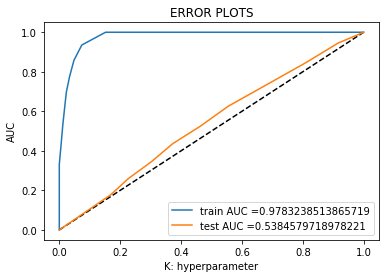

Train confusion matrix
[[13232   315]
 [ 4095  9452]]
Test confusion matrix
[[ 373  322]
 [1571 1734]]


In [41]:
# from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# the best hyper parameter obtained 
print(clf.best_params_)
optimal_k = clf.best_params_.get("n_neighbors")

neigh = KNeighborsClassifier(n_neighbors= optimal_k,algorithm='kd_tree',n_jobs= -1)
neigh.fit(standardized_data_train, y_train_tfidf_w2v)

y_pred_proba_train = neigh.predict_proba(standardized_data_train)[:,1]
y_pred_proba_test = neigh.predict_proba(standardized_data_test)[:,1]
train_fpr, train_tpr, thresholds = roc_curve(y_train_tfidf_w2v, y_pred_proba_train)
test_fpr, test_tpr, thresholds = roc_curve(y_test, y_pred_proba_test)

print("AUC score on train data: ",roc_auc_score(y_train_tfidf_w2v, y_pred_proba_train))
print("AUC score on test data: ",roc_auc_score(y_test, y_pred_proba_test))

plt.plot([0,1],[0,1],'k--')
plt.plot(train_fpr,train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr,test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.xlabel('K: hyperparameter')
plt.ylabel('AUC')
plt.title('ERROR PLOTS')
plt.legend()

plt.show()

print("="*100)

from sklearn.metrics import confusion_matrix

print("Train confusion matrix")
print(confusion_matrix(y_train_tfidf_w2v, neigh.predict(standardized_data_train)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(standardized_data_test)))

# [6] Conclusions

In [2]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyper parameter", "Train AUC", "Test AUC"]

x.add_row(["BOW", "Brute", 11, 0.96, 0.70])
x.add_row(["TFIDF", "Brute", 3, 0.99, 0.61])
x.add_row(["W2V", "Brute", 13, 0.98, 0.66])
x.add_row(["TFIDFW2V", "Brute", 11, 0.98,0.61])
x.add_row(["BOW", "kd_tree", 9, 0.97, 0.70])
x.add_row(["TFIDF", "kd_tree", 11, 0.96, 0.56])
x.add_row(["W2V", "kd_tree", 9, 0.98, 0.56])
x.add_row(["TFIDFW2V", "kd_tree", 9, 0.98, 0.54])

print(x)

+------------+---------+-----------------+-----------+----------+
| Vectorizer |  Model  | Hyper parameter | Train AUC | Test AUC |
+------------+---------+-----------------+-----------+----------+
|    BOW     |  Brute  |        11       |    0.96   |   0.7    |
|   TFIDF    |  Brute  |        3        |    0.99   |   0.61   |
|    W2V     |  Brute  |        13       |    0.98   |   0.66   |
|  TFIDFW2V  |  Brute  |        11       |    0.98   |   0.61   |
|    BOW     | kd_tree |        9        |    0.97   |   0.7    |
|   TFIDF    | kd_tree |        11       |    0.96   |   0.56   |
|    W2V     | kd_tree |        9        |    0.98   |   0.56   |
|  TFIDFW2V  | kd_tree |        9        |    0.98   |   0.54   |
+------------+---------+-----------------+-----------+----------+
